# Counting objects workflow

In this notebook we will illustrate a simple workflow, consisting of a number of simple steps, designed to accomplish the goal of **counting objects in a microscopy image**. 

You will learn how to:

* Open images
* Use filters to suppress noise
* Segment images using grey level thresholding
* Count objects
* Perform basic morphological quantification

### Import libraries
Python is organised in modules and packages. To make them available in our current notebook, we use the keywork `import`. We can also import specific functions by using the syntax [`from` module `import` function]. Additionally, we can define aliases for modules' names with the keyword `as`

You can check the documentation for the various modules if you want to know more!

* [`scikit_image`](https://scikit-image.org/docs/stable/api/skimage.html) (a.k.a. [`skimage`](https://scikit-image.org/docs/stable/api/skimage.html)) - image processing and computer vision
* [`matplotlib`](https://matplotlib.org/) - visualisations
* [`pandas`](https://pandas.pydata.org/docs/user_guide/index.html) - data managing

In [1]:
from skimage import io
from skimage import filters
from skimage import measure

import matplotlib.pyplot as plt

import pandas as pd

### Open images

To get started with our "counting objects" task, the first thing we need to do is to open an image. We will use an example image where some cell nuclei have been stained with DAPI and imaged with fluorescent microscopy ([`Nuclei.ome.tiff`](https://github.com/djpbarry/DAIM-MMC2023/blob/main/Images/Nuclei.ome.tiff) in the folder [`Images`](https://github.com/djpbarry/DAIM-MMC2023/tree/main/Images)). However, any images showing some blob-like objects will do! In fact, the same pipeline also works for [`HAADF _8MX _0008.tif`](https://github.com/djpbarry/DAIM-MMC2023/blob/main/Images/HAADF%20_8MX%20_0008.tif) with very minor adjustments.

Next, we will display our example image to screen - it's always good practice to get an idea about the kind of data we're working with

In [2]:
# read .tif file
im = io.imread('../Images/Nuclei.ome.tiff')

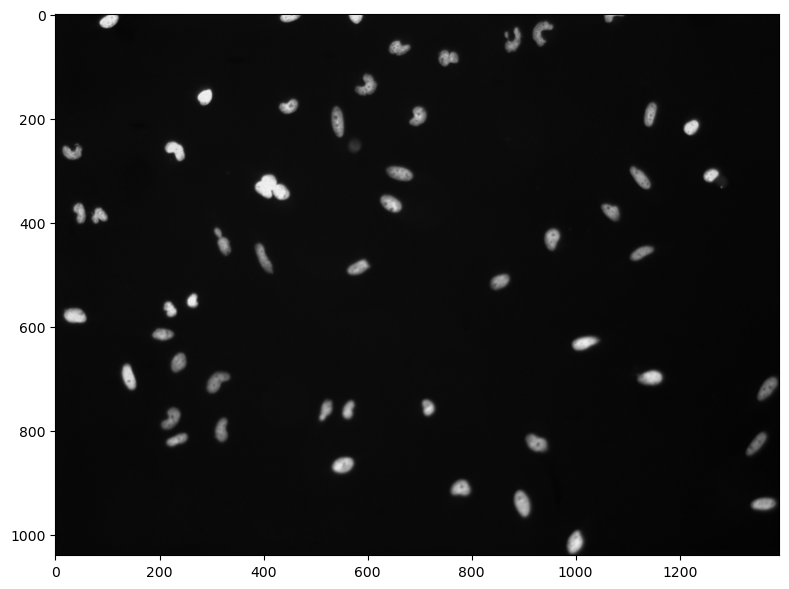

In [3]:
# display image
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(im, cmap='gray')
plt.tight_layout()

### Use filters to suppress noise

Many image processing tasks include filtering to suppress noise, improve signal-to-noise ratio, or bring out the features of the image we are interested in.

Please keep in mind that often by applying filters we change the histogram of the image, and, therefore, we won't be able to perform some quantifications related to signal intensity **after** filtering.

In this example, we are not interested in quantifying signal intensities (i.e., how bright the nuclei are), so we're good to proceed!

[`skimage`](https://scikit-image.org/docs/stable/api/skimage.html) has many filters already built in! You can find them in the submodule [`skimage.filters`](https://scikit-image.org/docs/stable/api/skimage.filters.html).

Here we'll test a [Gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur), which is a standard method to reduce image noise by blurring details. One important parameter is `sigma`, which is the standard deviation of the Gaussian kernel. You can think of it as the "size of the brush" you'll use to smooth the image features. Test what happens when changing the value of `sigma` in the next cell by displaying the results in the cell after next (remember to set the back `sigma=5` once you're done experimenting, as this parameter gives us good results in the following steps!)

In [4]:
# Gaussian blur (sigma=5)
im_gauss = filters.gaussian(im, sigma=5)

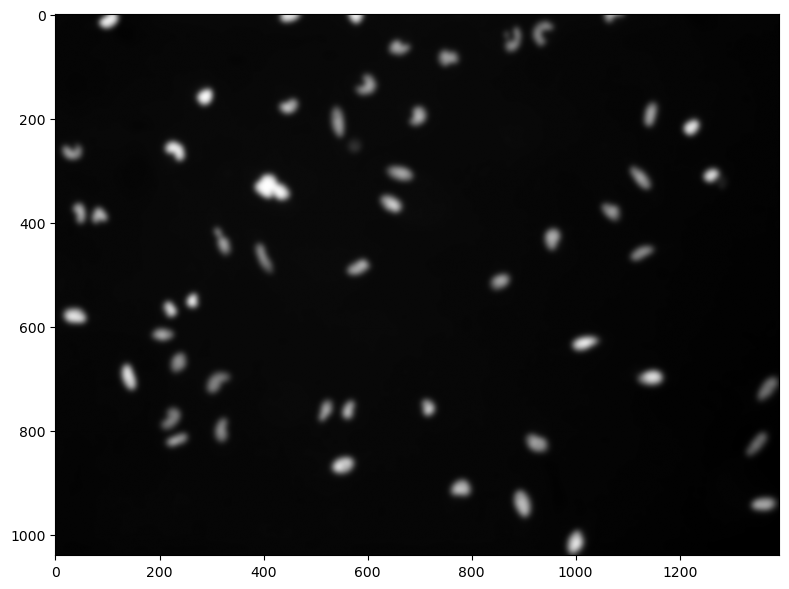

In [5]:
# display image
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(im_gauss, cmap='gray')
plt.tight_layout()

### Segment images using grey level thresholding

The next step in our pipeline is segmentation. This is the process by which we separate the foreground (`True`) from the background (`False`) so that the subsequent analyses are performed only on the regions of interest.

One simple way to segment images is by gray level thresholding: we "keep" all the pixels with values above a threshold (foreground) and we "discard" the rest (background).

There are different ways to set this threshold by exploiting different algorigthms. With the function [`skimage.filters.try_all_threshold`](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.try_all_threshold), we can visualise a few options and decide which one performs best for our data! [Otsu's thresholding](https://en.wikipedia.org/wiki/Otsu%27s_method) is a common choice for this type of images, so after checking its performance on the example image, we'll apply it.

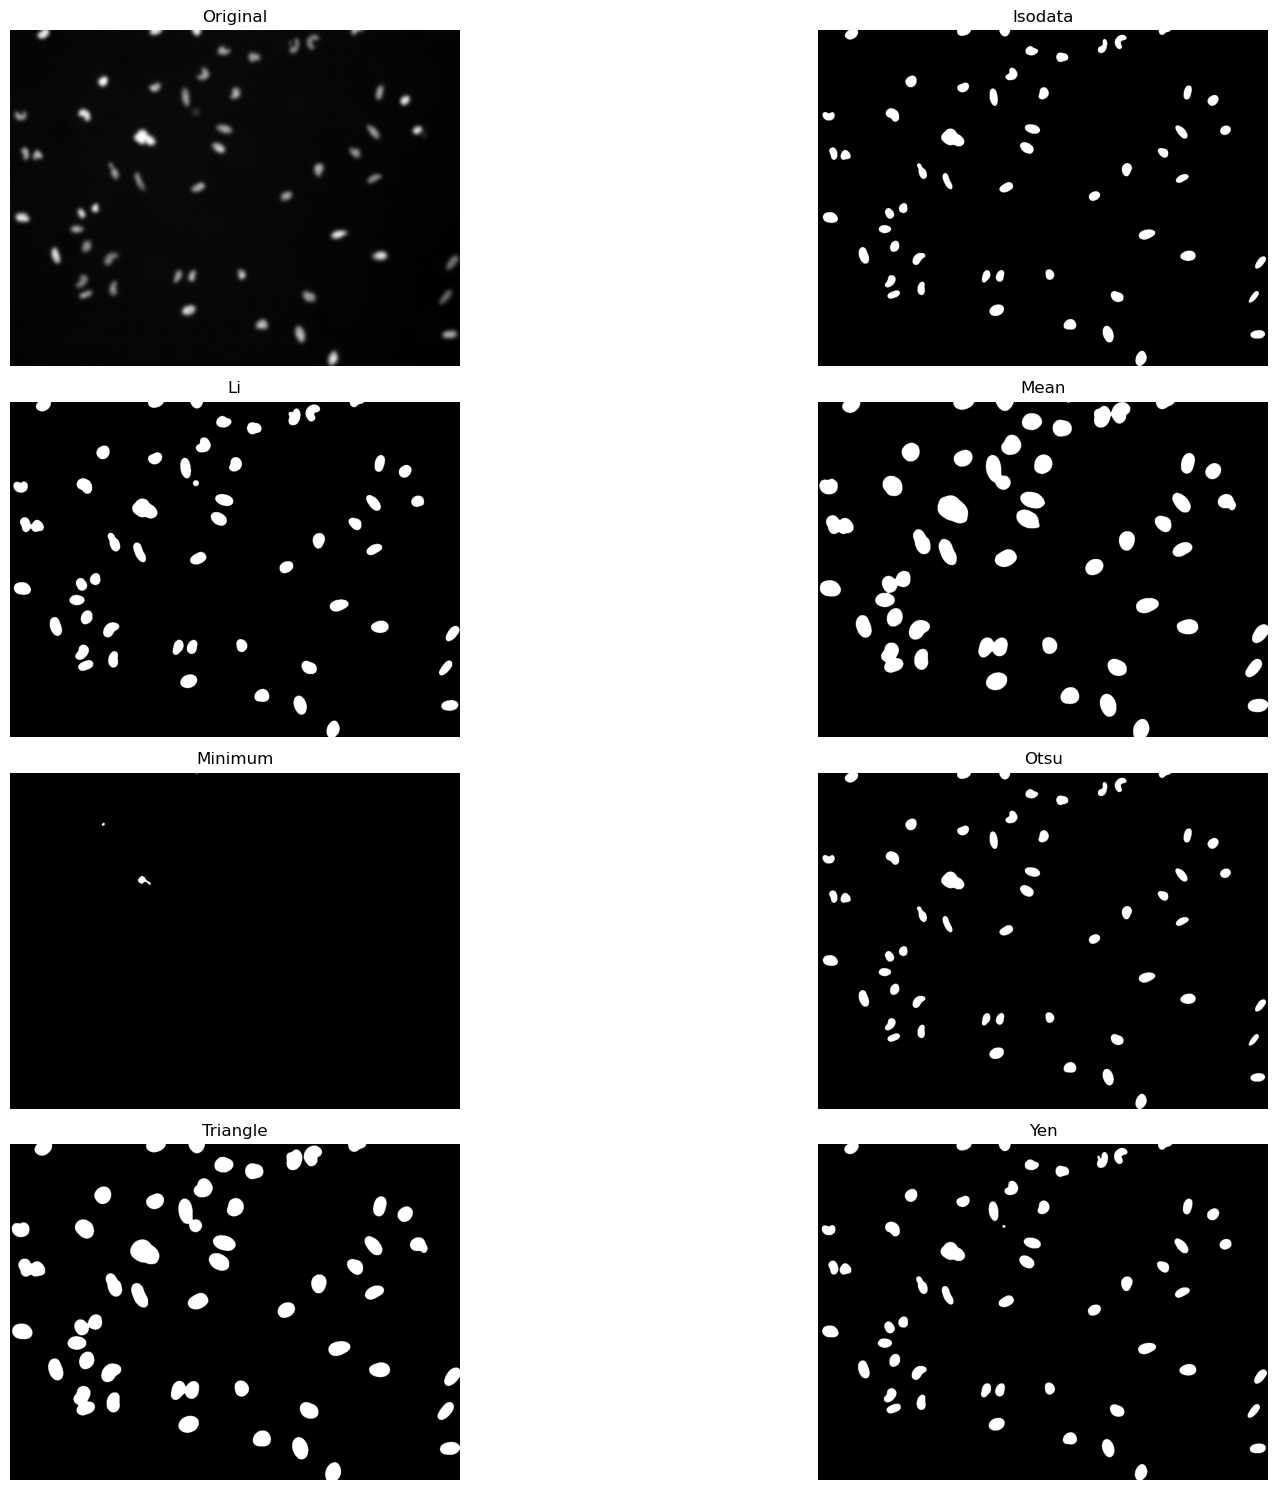

In [6]:
# display various options for gray level thresholding
fig, ax = filters.try_all_threshold(im_gauss, figsize=(20, 15), verbose=False)

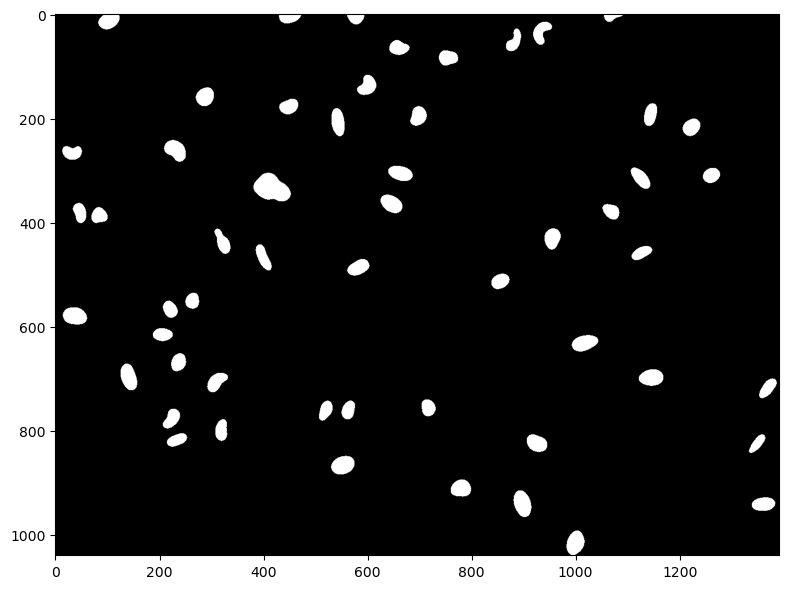

In [7]:
# Otsu thresholding performs quite well in this example, so we'll proceed by applying it to our image and display 
thresh = filters.threshold_otsu(im_gauss)
im_thresh = im_gauss >= thresh

fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(im_thresh, cmap='gray')
plt.tight_layout()

### Count objects

One way to count the objects in our thresholded image is to exploit the function [`skimage.measure.label`](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.label). This function labels connected regions in the image with an integer, ultimately assigning a label to each object.

After labelling, counting the objects is equivalent to counting the number of labels available in the image!

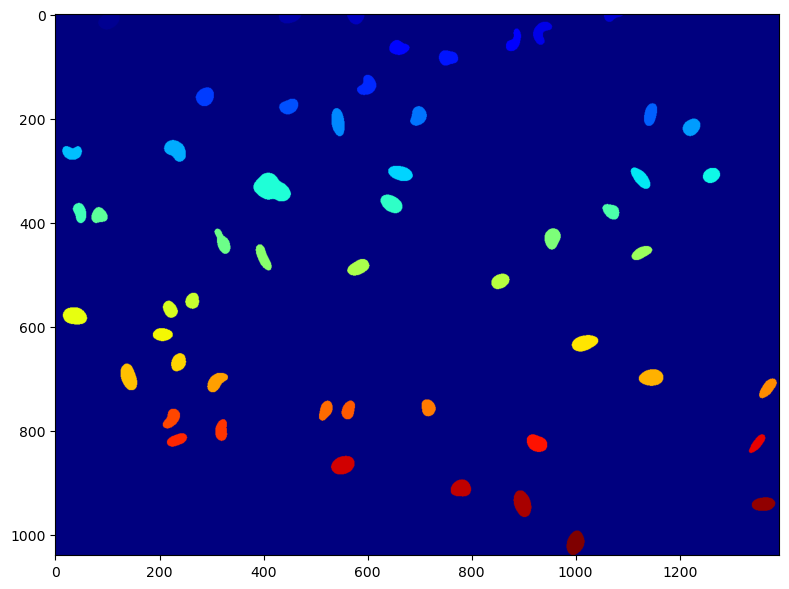

In [8]:
# label objects and visualise the result
labels = measure.label(im_thresh)

fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(labels, cmap='jet')
plt.tight_layout()

In [9]:
# count the objects - find the maximum integer assigned to a label!
print("There are {} objects in the image".format(labels.max()))

There are 54 objects in the image


### Perform basic morphological quantification
We can perform some basic morphological quantification by using the function [`skimage.measure.regionprops_table`](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops_table). Check the documentation to see all the different output we can obtain!

In this example, we are going to show the area, centroid (y and x coordinates), and eccentricity for each blob. We are going to save the data in a [Pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), which is a data structure containing labelled axes (one row for each object, one column for each feature).

In [10]:
# measure properties
props = measure.regionprops_table(labels, im, properties=['area', 'centroid', 'eccentricity'])
props_df = pd.DataFrame(props)

props_df.head(5)

,area,centroid-0,centroid-1,eccentricity
0,953.0,13.174187,102.962225,0.742835
1,615.0,7.229268,449.401626,0.902486
2,513.0,7.883041,577.362573,0.768216
3,358.0,5.201117,1068.483240,0.919255
4,930.0,34.115054,933.132258,0.826827


### Bonus track
It is always good practice to visualise our results! So we can now display on the segmented image some of the basic morphological parameters we obtained. As an example, we show the centroids of each blob as a magenta dot. Can you spot where things have not gone exactly as expected?

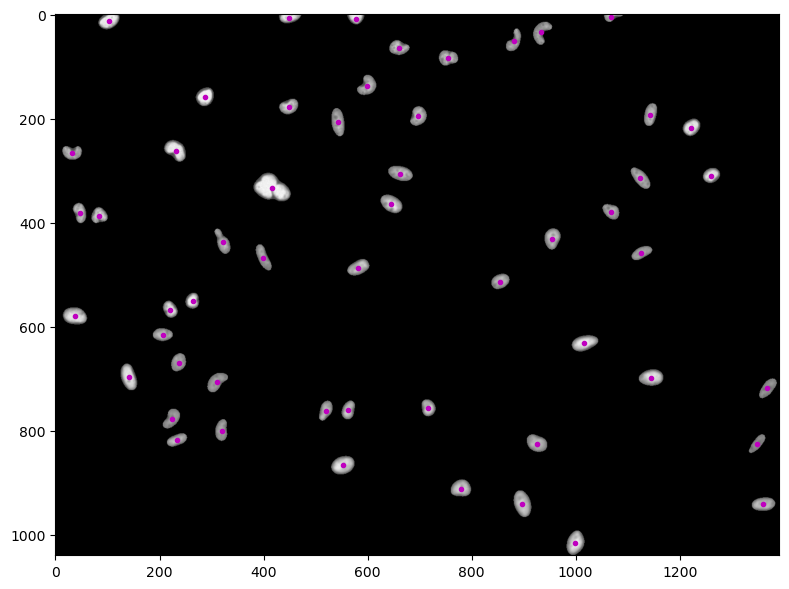

In [11]:
# display segmented image
im_segm = im * im_thresh

fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(im_segm, cmap='gray')
plt.tight_layout()

# plot centroids
plt.plot(props_df['centroid-1'], props_df['centroid-0'], 'm.')
plt.show()

### Further reading
If you're interested in knowing more about image analysis in Python, there are a lot of free resources out there! One good starting point is the [IAFIG-RMS Python for Bioimage Analysis Course](https://github.com/RMS-DAIM/Python-for-Bioimage-Analysis). Good luck with your image analysis adventures!